# DeepAutoRec

- [Training Deep AutoEncoders for Collaborative Filtering](https://arxiv.org/pdf/1708.01715.pdf)

## Experiment

- Relation of latent dimension and the size of data
    - For small size of data, too large latent dimension makes it overfitting
- More than 2 layers bring about overfitting
- No Dropout has the best perfomance
- Is Re-feeding effective?

In [ ]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Layer, Subtract
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [ ]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [ ]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 0s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [ ]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [ ]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [ ]:
ratings = Id2idx(ratings)
ratings.head(5)

,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [ ]:
def data_split(df: pd.DataFrame, test_size = 0.1) -> pd.DataFrame:
    timeorder = df.groupby(by = 'userId')['timestamp'].rank(method = 'first', ascending = True)
    seen_cnt = df.groupby(by = 'userId', as_index = False)['movieId'].agg('count').rename(columns = {'movieId': 'cnts'})

    df = df.merge(seen_cnt, how = 'left', on = 'userId')
    df = df.assign(timeorder = timeorder)
    df = df.assign(split_type = lambda x: np.where(x.timeorder > x.cnts * test_size, 'train', 'test')) # 시간을 기준으로 train과 valid&test 분할

    train = df[df.split_type == 'train']
    test = df[df.split_type == 'test']
    
    valid, test = train_test_split(test, test_size = 0.5, stratify = test.userId, random_state = 7777)
    valid, test = map(lambda df: df[df.userId.isin(train.userId.unique()) & df.movieId.isin(train.movieId.unique())], (valid, test)) # train에 속하지 않는 user 및 movie 삭제

    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    train, valid, test = map(lambda df: df.drop(columns = ['cnts', 'timeorder', 'split_type']), (train, valid, test))

    return train, valid, test

In [ ]:
def make_interaction(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [ ]:
def make_generator(df: pd.DataFrame,
                   n_item: int,
                   batch_size: int,
                   implicit = False,
                   threshold = 3.5,
                   refeed = True) -> Tuple[np.array, Tuple[np.array, np.array]]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                batch[i, profile[idx]] = rating[idx]
            
            zeros = np.zeros(shape = (batch_Id.size, n_col))
            if refeed:
                yield batch, (batch, zeros)
            else:
                yield batch, batch

In [ ]:
def mse(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    se = K.square(y_true - y_pred)
    return K.mean(se, axis = -1)

def rmse(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    se = K.square(y_true - y_pred)
    return K.sqrt(K.mean(se, axis = -1))
    
def masked_mse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    return K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

In [ ]:
def DeepAutoRec(n_item: int, 
                n_layer = 3,
                latent_dim = 1024,
                activation = 'selu', 
                optimizer = 'adam', 
                learning_rate = 0.001,
                kernel_initializer = None,
                kernel_regularizer = None, 
                dropout_rate = 0.8,
                refeed = True) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    input_shape = n_item

    # encoder
    encoders = []
    for i in range(n_layer-1):
        encoders.append(Dense(latent_dim // 2, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = f'encoder_{i+1}'))
    encoders.append(Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = f'encoder_{n_layer}'))

    # decoder
    decoders = []
    for i in range(n_layer-1):
        decoders.append(Dense(latent_dim // 2, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = f'decoder_{i+1}'))
    decoders.append(Dense(input_shape, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = f'decoder_{n_layer}'))

    # forward propagate
    inputs = x = Input(shape = (input_shape, ), name = 'input')
    for i in range(n_layer):
        x = encoders[i](x)
    x = Dropout(dropout_rate, name = 'dropout')(x)

    for i in range(n_layer):
        x = decoders[i](x)
    outputs = y = Layer(name = 'output')(x)
    
    # re-feeding
    if refeed:
        for i in range(n_layer):
            y = encoders[i](y)

        for i in range(n_layer):
            y = decoders[i](y)
        refeeded = Subtract(name = 'refeeded')([outputs, y]) # f(x) - f(f(x))

        model = Model(inputs = [inputs], outputs = [outputs, refeeded])
        model.compile(optimizer = optimizer, loss = {'output': masked_mse, 'refeeded': mse}, loss_weights = [0.9, 0.1], metrics = {'output': masked_rmse, 'refeeded': rmse})
    
    else:
        model = Model(inputs = inputs, outputs = outputs)
        model.compile(optimizer = optimizer, loss = masked_mse, metrics = masked_rmse)
    return model

In [ ]:
def make_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = False, 
                   threshold = 3.5,
                   refeed = True) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res: float = 0.0
    N: int = 0
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        if refeed:
            y_pred = model.predict(y_true, verbose = 0)[0]
        else:
            y_pred = model.predict(y_true, verbose = 0)

        res += np.sum(masked_rmse(y_true, y_pred).numpy())
        N += batch_Id.size
    return res / N

In [ ]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_rmse', 'val_masked_rmse'], loc = 'upper right')
    plt.show()

## 2. Vanilla

In [ ]:
epochs = 500
batch_size = 128

train, valid, test = data_split(ratings)
train, valid, test = map(make_interaction, (train, valid, test))
train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, refeed = False), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1

In [ ]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = DeepAutoRec(n_item, n_layer = 2, latent_dim = 1024, optimizer = optimizer, dropout_rate = 0.2, refeed = False)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder_1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
encoder_2 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
decoder_1 (Dense)            (None, 512)               524800    
_________________________________________________________________
decoder_2 (Dense)            (None, 3706)              1901178   
_________________________________________________________________
output (Layer)               (None, 3706)             

In [ ]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('DeepAutoRec_1M.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
48/48 [==============================] - 1s 24ms/step - loss: 5.6889 - masked_rmse: 1.9691 - val_loss: 2.7002 - val_masked_rmse: 1.1413
Epoch 2/500
48/48 [==============================] - 2s 35ms/step - loss: 2.4352 - masked_rmse: 1.1485 - val_loss: 2.5466 - val_masked_rmse: 1.0965
Epoch 3/500
48/48 [==============================] - 2s 33ms/step - loss: 2.2149 - masked_rmse: 1.0734 - val_loss: 2.5227 - val_masked_rmse: 1.1031
Epoch 4/500
48/48 [==============================] - 1s 20ms/step - loss: 2.0564 - masked_rmse: 1.0202 - val_loss: 2.5284 - val_masked_rmse: 1.1150
Epoch 5/500
48/48 [==============================] - 1s 19ms/step - loss: 1.9378 - masked_rmse: 0.9823 - val_loss: 2.5574 - val_masked_rmse: 1.1391
Epoch 6/500
48/48 [==============================] - 1s 20ms/step - loss: 1.8218 - masked_rmse: 0.9422 - val_loss: 2.6442 - val_masked_rmse: 1.1795
Epoch 7/500
48/48 [==============================] - 1s 21ms/step - loss: 1.7235 - masked_rmse: 0.9084 - val_los

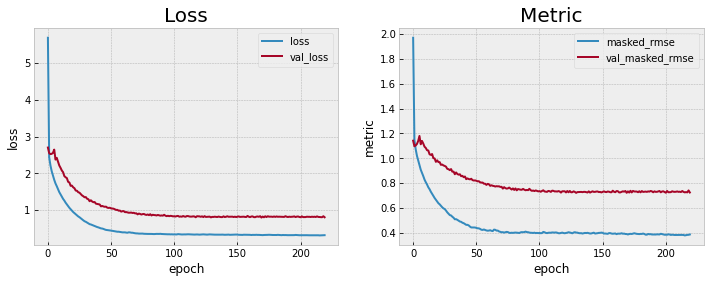

In [ ]:
show_history(hist, 'loss', 'masked_rmse')

In [ ]:
test_pred = make_predictor(test, model, n_item, batch_size, refeed = False)
print(f'Mean of masked RMSE: {test_pred:.4f}')

Mean of masked RMSE: 0.7157


## 3. Re-feeding

In [ ]:
epochs = 500
batch_size = 128

train, valid, test = data_split(ratings)
train, valid, test = map(make_interaction, (train, valid, test))
train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size), (train, valid))

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1

In [ ]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = DeepAutoRec(n_item, n_layer = 2, latent_dim = 1024, optimizer = optimizer, dropout_rate = 0.2)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 512)          1897984     input[0][0]                      
                                                                 output[0][0]                     
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 1024)         525312      encoder_1[0][0]                  
                                                                 encoder_1[1][0]                  
_______________________________________________________________________________________

In [ ]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('DeepAutoRec_1M.h5', monitor = 'val_output_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
48/48 [==============================] - 1s 31ms/step - loss: 5.3316 - output_loss: 4.2754 - refeeded_loss: 2.9197 - output_masked_rmse: 1.8892 - refeeded_rmse: 1.3969 - val_loss: 2.8066 - val_output_loss: 1.6405 - val_refeeded_loss: 1.6039 - val_output_masked_rmse: 1.1390 - val_refeeded_rmse: 1.0437
Epoch 2/500
48/48 [==============================] - 2s 35ms/step - loss: 2.2717 - output_loss: 1.2369 - refeeded_loss: 0.1232 - output_masked_rmse: 1.0929 - refeeded_rmse: 0.3369 - val_loss: 2.6628 - val_output_loss: 1.5450 - val_refeeded_loss: 1.5271 - val_output_masked_rmse: 1.0977 - val_refeeded_rmse: 0.9727
Epoch 3/500
48/48 [==============================] - 1s 21ms/step - loss: 2.1078 - output_loss: 1.1167 - refeeded_loss: 0.0874 - output_masked_rmse: 1.0389 - refeeded_rmse: 0.2718 - val_loss: 2.8221 - val_output_loss: 1.7384 - val_refeeded_loss: 1.9129 - val_output_masked_rmse: 1.1538 - val_refeeded_rmse: 1.1233
Epoch 4/500
48/48 [==============================] - 1s 22

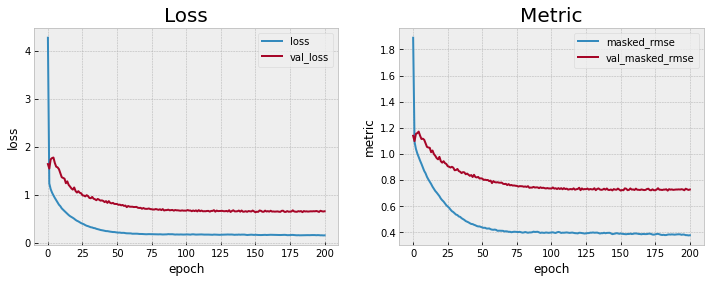

In [ ]:
show_history(hist, 'output_loss', 'output_masked_rmse')

In [ ]:
test_pred = make_predictor(test, model, n_item, batch_size)
print(f'Mean of masked RMSE: {test_pred:.4f}')

Mean of masked RMSE: 0.7129
